# Knowledge distillation proof of concept 

$\approx 1.5$M parameters down to $\approx 25$k parameters.

![](Images/overview.png)

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, Input, Dense, Lambda, concatenate, Dropout, Flatten, Activation
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.special import softmax
import matplotlib.pyplot as plt
import numpy as np
import os
from utils import *

### Set hyper parameters

In [12]:
epochs = 100
batch_size = 1000
nb_classes = 10
input_shape = (28, 28, 1)
temp = 170

### Define teacher model

In [3]:
teacher = make_teacher(input_shape, nb_classes)
teacher.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

### Define smaller model

In [4]:
student = small_net(input_shape, nb_classes)
student.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
_________________________________________________________________


### Load data

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)

### Train teacher model

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('bestTeacherModel.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = teacher.fit(x_train, y_train,
          batch_size=100,
          epochs=50,
          verbose=1,
          validation_split=0.2,
          callbacks = [es, model_checkpoint])

### Evaluate teacher on test set

In [6]:
teacher = load_model('bestTeacherModel.h5')
teacher.evaluate(x_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.12470176129342006, 0.977]

### Extract soft targets from the teacher

In [7]:
# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('logits').output)

# Used for saving time
if not os.path.exists('teacher_train_logits.npy'):
    teacher_train_logits = teacher_WO_Softmax.predict(x_train)
    teacher_test_logits = teacher_WO_Softmax.predict(x_test)
    np.save('teacher_train_logits', teacher_train_logits)
    np.save('teacher_test_logits', teacher_test_logits)
else:
    teacher_train_logits = np.load('teacher_train_logits.npy')
    teacher_test_logits = np.load('teacher_test_logits.npy')

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits / temp
test_logits_T = teacher_test_logits / temp

y_train_soft = softmax(train_logits_T, axis = 1)
y_test_soft = softmax(test_logits_T, axis = 1)

# Concatenate so that this becomes a 10 + 10 dimensional vector
y_train_new = np.concatenate([y_train, y_train_soft], axis=1)
y_test_new = np.concatenate([y_test, y_test_soft], axis =1)

### Compare hard / soft targets
- Hard targets are simply given by the one-hot labels
- Soft targets are given by applying a temperature controlled softmax to the logits $z_i$ according to:

$$\quad q_i=\frac{\exp(z_i/T)}{\sum_j\exp(z_j/T)}$$

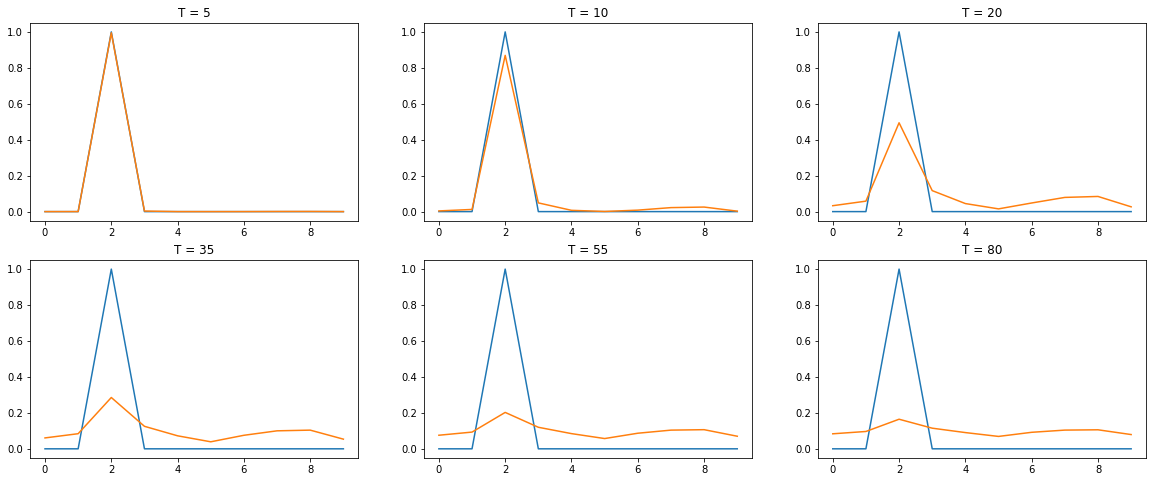

In [8]:
test_temp = 5
plt.rcParams["figure.figsize"] = (20,8)
for i in range(6):
    test_temp = test_temp + i*5
    test_train_logits_T = teacher_train_logits / test_temp
    test_test_logits_T = teacher_test_logits / test_temp
    y_train_soft = softmax(test_train_logits_T, axis = 1)
    y_test_soft = softmax(test_test_logits_T, axis = 1)
    plt.subplot(2, 3, i+1)
    plt.title('T = ' + str(test_temp))
    plt.plot(y_test[1337])
    plt.plot(y_test_soft[1337])
plt.show()




### Hinton et. al modelled the loss according to

$$\mathcal{L} = \alpha\times logloss(y_{gt}, y_{pred}) + \beta\times logloss(y_{soft}, y_{predSoft})$$

In our case, the hyperparameters $\alpha$ and $\beta$ are set to 0.1 and 1.0 respectively.

### Train small model normally

In [18]:
vanilla_val_acc = []
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
for i in range(10):
    
    vanilla_net = small_net(input_shape, nb_classes)
    vanilla_net.add(Activation('softmax'))
    vanilla_net.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    vanilla_net.fit(x_train, y_train, 
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_split=0.2,
              callbacks = [es])
    
    vanilla_val_acc.append(vanilla_net.history.history['val_acc'][-1])
    print('Training', i+1, 'done')

Training 1 done
Training 2 done
Epoch 00084: early stopping
Training 3 done
Epoch 00094: early stopping
Training 4 done
Epoch 00089: early stopping
Training 5 done
Training 6 done
Epoch 00059: early stopping
Training 7 done
Training 8 done
Training 9 done
Epoch 00093: early stopping
Training 10 done


### Train small model using KD

In [19]:
student_val_acc = []
for i in range(10):

    student = small_net(input_shape, nb_classes)
    logits = student.output
    probs = Activation('softmax')(logits)

    # softed probabilities at raised temperature
    logits_T = Lambda(lambda x: x / temp)(logits)
    probs_T = Activation('softmax', name = '')(logits_T)

    output = concatenate([probs, probs_T])

    # This is our new student model
    student = Model(student.input, output)

    student.compile(
        optimizer='adam',
        loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, nb_classes),
        metrics=[acc])
    student.fit(x_train, y_train_new,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_split=0.2,
              callbacks = [es])
    
    student_val_acc.append(student.history.history['val_acc'][-1])
    print('Training', i+1, 'done')


Epoch 00056: early stopping
Training 1 done
Epoch 00065: early stopping
Training 2 done
Epoch 00056: early stopping
Training 3 done
Epoch 00062: early stopping
Training 4 done
Epoch 00061: early stopping
Training 5 done
Epoch 00048: early stopping
Training 6 done
Epoch 00064: early stopping
Training 7 done
Epoch 00074: early stopping
Training 8 done
Epoch 00073: early stopping
Training 9 done
Epoch 00064: early stopping
Training 10 done


# RESULTS

### Info from running training 20 times on the small model with & without KD using 80\% of the training data

In [20]:
print('Without KD','\n','Mean:', np.mean(vanilla_val_acc), '\n', 'Variance:', np.var(vanilla_val_acc))   
print('-'*24)
print('With KD','\n','Mean:', np.mean(student_val_acc), '\n', 'Variance:', np.var(student_val_acc))

Without KD 
 Mean: 0.92765826 
 Variance: 1.4136756e-05
------------------------
With KD 
 Mean: 0.94085824 
 Variance: 1.2708346e-05


## Some further testing using only 5\% of the training data

In [21]:
testNet1 = small_net(input_shape, nb_classes)
logits = testNet1.output
probs = Activation('softmax', name = 'normal_softmax')(logits)

# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
testNet1 = Model(testNet1.input, output)

testNet1.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, nb_classes),
    metrics=[acc])

testNet1.fit(x_train, y_train_new,
            batch_size=batch_size,
            epochs=100,
            verbose=0,
            validation_split=0.95)

In [22]:
testNet2 = small_net(input_shape, nb_classes)
testNet2.add(Activation('softmax'))
testNet2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

testNet2.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=100,
            verbose=0,
            validation_split=0.95)

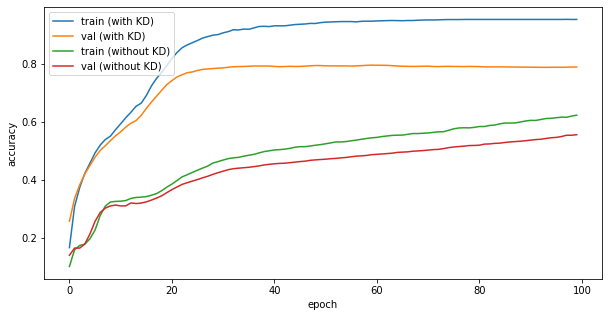

In [23]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(testNet1.history.history['acc'])
plt.plot(testNet1.history.history['val_acc'])
plt.plot(testNet2.history.history['acc'])
plt.plot(testNet2.history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train (with KD)', 'val (with KD)', 'train (without KD)', 'val (without KD)'], loc='upper left')

plt.show()

In [25]:
student = Model(testNet1.input, testNet1.get_layer('normal_softmax').output)
student.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
student.evaluate(x_test,y_test, verbose = 0)

[4.279091316915437, 0.8018]

In [26]:
testNet2.evaluate(x_test,y_test, verbose = 0)

[1.749926845741272, 0.5539]

In [29]:
vanilla_val_acc = []
for i in range(5):
    
    vanilla_net = small_net(input_shape, nb_classes)
    vanilla_net.add(Activation('softmax'))
    vanilla_net.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    vanilla_net.fit(x_train, y_train, 
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_split=0.95, callbacks = [es])
    
    vanilla_val_acc.append(vanilla_net.history.history['val_acc'][-1])
    print('Training', i+1, 'done')
    
student_test_acc = []
for i in range(5):

    student = small_net(input_shape, nb_classes)
    logits = student.output
    probs = Activation('softmax')(logits)

    # softed probabilities at raised temperature
    logits_T = Lambda(lambda x: x / temp)(logits)
    probs_T = Activation('softmax', name = '')(logits_T)

    output = concatenate([probs, probs_T])

    # This is our new student model
    student = Model(student.input, output)

    student.compile(
        optimizer='adam',
        loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, nb_classes),
        metrics=[acc])
    student.fit(x_train, y_train_new,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_split=0.95, callbacks = [es])
    
    student_val_acc.append(student.history.history['val_acc'][-1])
    print('Training', i+1, 'done')

Training 1 done
Epoch 00089: early stopping
Training 2 done
Training 3 done
Training 4 done
Training 5 done
Epoch 00080: early stopping
Training 1 done
Epoch 00071: early stopping
Training 2 done
Training 3 done
Epoch 00087: early stopping
Training 4 done
Training 5 done


In [30]:
print('Without KD','\n','Mean:', np.mean(vanilla_val_acc), '\n', 'Variance:', np.var(vanilla_val_acc))   
print('-'*24)
print('With KD','\n','Mean:', np.mean(student_val_acc), '\n', 'Variance:', np.var(student_val_acc))

Without KD 
 Mean: 0.4176526 
 Variance: 0.023991391
------------------------
With KD 
 Mean: 0.8760847 
 Variance: 0.0071209697
